In [ ]:
!pip install -U layoutparser

     |████████████████████████████████| 19.1MB 1.7MB/s 
     |████████████████████████████████| 645kB 41.3MB/s 
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2' 

  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.4) to /tmp/pip-install-8ps3rqfh/detectron2
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-install-8ps3rqfh/detectron2
  Running command git checkout -q 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1
     |████████████████████████████████| 51kB 2.7MB/s 
  Created wheel for detectron2: filename=detectron2-0.4-cp37-cp37m-linux_x86_64.whl size=5038468 sha256=e875c88568fcbdb6d02c7b7194389dc1897295f81498f7f856681649ec8970a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-h8oni59o/wheels/24/b4/77/2e5f8651761d4b6bd53b5e024a97583d9b043636c0c077ad4d
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=df54fc7a27b6bdf58df5b11f61bd8a05cba137b8d5721763ce163603f6e55c75
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
Successfully built detectron2 fvcore


In [ ]:
import layoutparser as lp
import numpy as np
import urllib
import cv2
import copy
from pprint import pprint

In [ ]:
# adapted from https://www.pyimagesearch.com/2015/03/02/convert-url-to-image-with-python-and-opencv/
def url_to_image(url):
    with urllib.request.urlopen(url) as resp:
        image = np.asarray(bytearray(resp.read()), dtype='uint8')
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        return image

In [ ]:
def list_pop_multiple(l, ids):
    ids = sorted(ids, reverse=True)
    for id_ in ids:
        l.pop(id_)

def compute_iou(box1, box2):

    box1_area = (box1.x_2 - box1.x_1) * (box1.y_2 - box1.y_1)
    box2_area = (box2.x_2 - box2.x_1) * (box2.y_2 - box2.y_1)
    
    if (box1.x_1 <= box2.x_1 <= box1.x_2 or box1.x_1 <= box2.x_2 <= box1.x_2
        or box2.x_1 <= box1.x_1 <= box2.x_2 or box2.x_1 <= box1.x_2 <= box2.x_2) \
            and (box1.y_1 <= box2.y_1 <= box1.y_2 or box1.y_1 <= box2.y_2 <= box1.y_2
                 or box2.y_1 <= box1.y_1 <= box2.y_2 or box2.y_1 <= box1.y_2 <= box2.y_2):
        inter_x_1 = max(box1.x_1, box2.x_1)
        inter_y_1 = max(box1.y_1, box2.y_1)
        inter_x_2 = min(box1.x_2, box2.x_2)
        inter_y_2 = min(box1.y_2, box2.y_2)
        inter_area = (inter_x_2 - inter_x_1) * (inter_y_2 - inter_y_1)
    else:
        inter_area = 0

    iou = inter_area / (box1_area + box2_area - inter_area)
    return iou

def combine_boxes(box1, box2):
    x_1 = min(box1.x_1, box2.x_1)
    y_1 = min(box1.y_1, box2.y_1)
    x_2 = max(box1.x_2, box2.x_2)
    y_2 = max(box1.y_2, box2.y_2)
    return box1.__class__(x_1, y_1, x_2, y_2)
    
def test_model(url, config_path):
    model = lp.Detectron2LayoutModel(config_path,
                                     extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.01])

    image = url_to_image(url)
    layout = model.detect(image)

    return (image, layout)

def improve_layout(layout, iou_thresh=0.25):
    layout = copy.deepcopy(layout)

    while True:
        box_changed = False
        changed_ids = None
        for i in range(len(layout)):
            block1 = layout[i]
            for j in range(len(layout)):
                if i < j:
                    block2 = layout[j]
                    iou = compute_iou(block1.block, block2.block)
                    #print(i, j, iou)
                    if iou > iou_thresh:
                        new_box = combine_boxes(block1.block, block2.block)
                        new_block = block1.__class__(block=new_box, score=1)
                        box_changed = True
                        changed_ids = [i, j]
                        break
            if box_changed:
                list_pop_multiple(layout, changed_ids)
                layout.append(new_block)
                break
        if not box_changed:
            break
    new_layout = []
    for block in layout:
        if block.score == 1:
            new_layout.append(block)
        else:
            new_layout.append(block.__class__(block=block.block, score=1))
    return new_layout

config.yml?dl=1: 8.19kB [00:01, 5.44kB/s]
model_final.pth?dl=1: 330MB [00:08, 39.0MB/s]                           


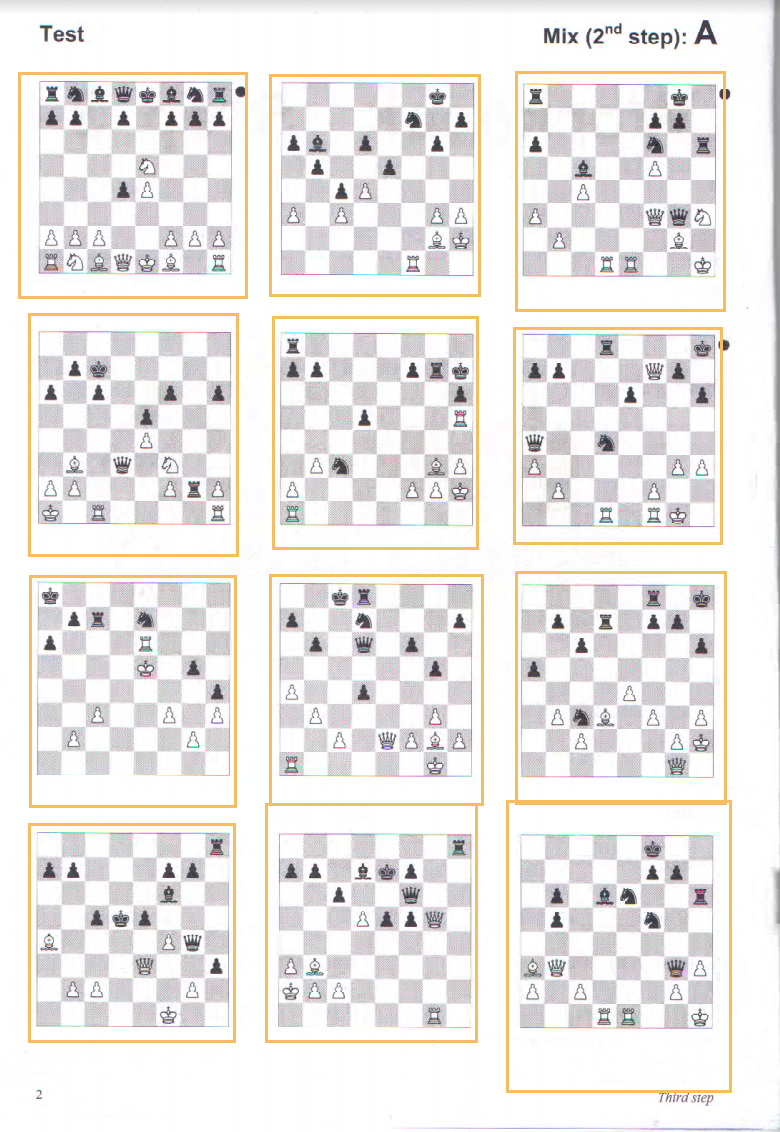

In [ ]:
url = 'https://i.imgur.com/g1vcpbw.png'
conf = 'lp://NewspaperNavigator/faster_rcnn_R_50_FPN_3x/config'
im, lay = test_model(url, conf)
imp_lay = improve_layout(lay)
lp.draw_box(im, imp_lay)